<a href="https://colab.research.google.com/github/Nouran-Khallaf/Arabic-Readability-Corpus/blob/main/text_classification_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with AG News Dataset

In this session, we will:
- Understand text classification.
- Visualize and explore the AG News dataset.
- Build models using:
  - TF-IDF + Naive Bayes
  - TF-IDF + Logistic Regression
  - FastText Embedding Averaging + Logistic Regression
  - Fine-tuning RoBERTa (Transformer)
- Evaluate using Confusion Matrices and ROC Curves.
- Analyze Errors.

##  Install and Import Required Libraries

In [16]:
!pip install -q datasets transformers scikit-learn torch matplotlib wordcloud seaborn pandas


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from datasets import load_dataset
from transformers import AutoTokenizer, RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, accuracy_score



##  Loading the AG News Dataset

In this step, we load the **AG News** dataset using the Hugging Face `datasets` library.  
This dataset consists of news articles categorized into four classes: **World**, **Sports**, **Business**, and **Sci/Tech**.

- We shuffle the dataset using a fixed `seed=42` to ensure **reproducibility** — every time we rerun, we get the same order.
- To speed up experiments, we **select only random 5000 examples** instead of using the entire dataset (~120,000 samples).
- We store the selected samples in a Pandas `DataFrame` for easier processing and visualization later.

Finally, we display the **first few rows** to verify the data structure.


In [3]:
dataset = load_dataset("ag_news")
df = pd.DataFrame(dataset['train'].shuffle(seed=42).select(range(5000)))
df.head()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

,text,label
0,Bangladesh paralysed by strikes Opposition act...,0
1,Desiring Stability Redskins coach Joe Gibbs ex...,1
2,Will Putin #39;s Power Play Make Russia Safer?...,0
3,U2 pitches for Apple New iTunes ads airing dur...,3
4,S African TV in beheading blunder Public broad...,0


## Visualizing Class Distribution

Before training any model, it is important to understand the **balance of classes** in our dataset.

- We map the original numeric labels (`0`, `1`, `2`, `3`) to **human-readable category names**:  
  - 0 → World  
  - 1 → Sports  
  - 2 → Business  
  - 3 → Sci/Tech

- Then, we use **Seaborn's `countplot`** to visualize how many samples belong to each class.

This helps us detect if the dataset is **imbalanced** (some classes much larger than others), which could bias our model later.  
In AG News, the classes are fairly **evenly distributed**, which is good for classification tasks.


<ipython-input-4-a3d6f1b4cc43>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_name', data=df, palette='viridis')


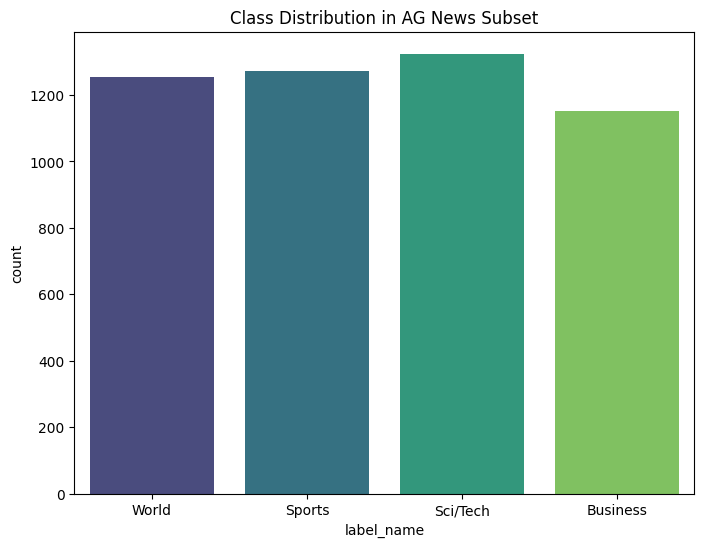

In [4]:
label_names = ['World', 'Sports', 'Business', 'Sci/Tech']
df['label_name'] = df['label'].apply(lambda x: label_names[x])

# Plot class distribution
plt.figure(figsize=(8,6))
sns.countplot(x='label_name', data=df, palette='viridis')
plt.title('Class Distribution in AG News Subset')
plt.show()




## ☁️ Word Cloud Visualization for Each Class

To get an **intuitive understanding** of the text data, we generate **Word Clouds** for each news category.

- A **Word Cloud** shows the most frequent words in a text dataset, where the size of each word reflects its frequency.
- For each class (`World`, `Sports`, `Business`, `Sci/Tech`), we:
  - Combine all article texts.
  - Generate a Word Cloud from the combined text.
  - Display it using Matplotlib.

This helps us quickly **see important keywords** typically associated with each category,  
which can guide feature engineering and model design later.


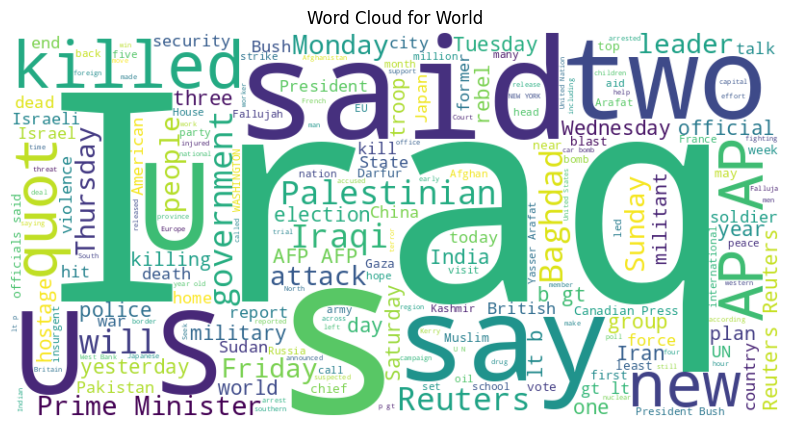

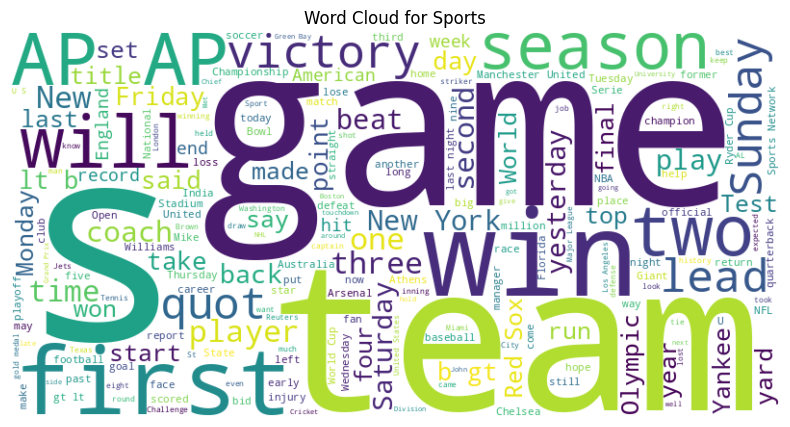

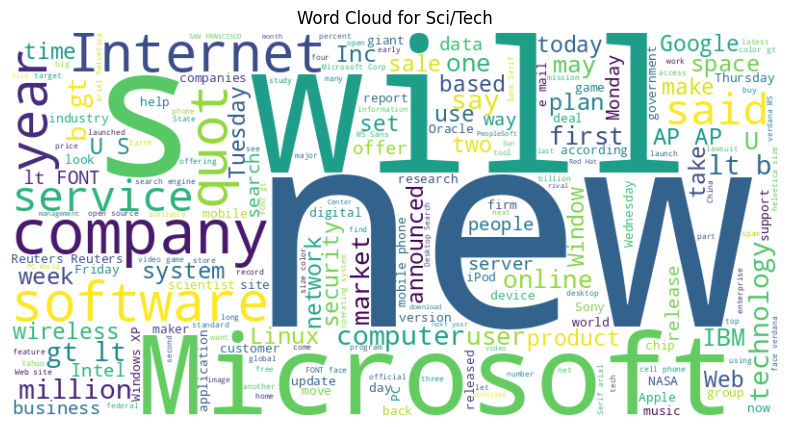

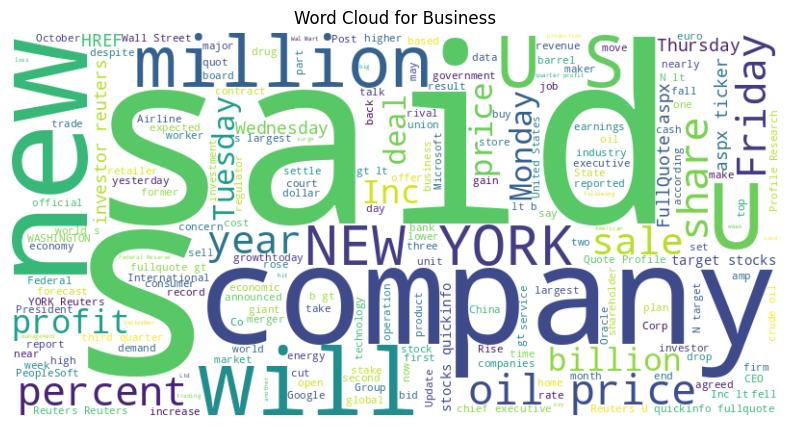

In [5]:
# Word Clouds
for label in df['label_name'].unique():
    text = " ".join(df[df['label_name'] == label]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {label}")
    plt.show()

## Text Preprocessing: Lowercasing and Splitting

Before feeding text into machine learning models, we apply **basic text preprocessing** to standardize the input.

- We **convert all text to lowercase** using a simple `preprocess` function.
  - This ensures that words like "Apple" and "apple" are treated the same.
- After preprocessing, we **split** the dataset into:
  - **Training set** (80%) — used to fit the model.
  - **Test set** (20%) — used to evaluate the model’s performance.

The `train_test_split` function ensures a **random but reproducible** division (`random_state=42`) for fair experiments.


In [7]:
def preprocess(text):
    return text.lower()

df['text'] = df['text'].apply(preprocess)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)


## Label Mapping for Interpretability

Machine learning models typically work with **numeric labels** (e.g., `0`, `1`, `2`, `3`).  
However, for better **interpretability** and **readability** in evaluation reports,  
we create a **mapping** from numbers to **human-readable category names**.

- `label_names` maps each class index to its corresponding class name.
- `target_names` creates a list combining both the numeric label and the class name, like `0 - World`, `1 - Sports`, etc.

This will make the **classification reports** and **confusion matrices** much easier to understand later on.


In [26]:
# Define label mapping
label_names = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
target_names = [f"{key} - {value}" for key, value in label_names.items()]

## Classification vs Regression

- **Classification**: Predict *discrete* labels (e.g., news topic: Business, Sports).
- **Regression**: Predict *continuous* values (e.g., house price, stock price).



##  1- Building a Baseline Model: TF-IDF + Naive Bayes

Our first model combines two classical text processing techniques:

- **TF-IDF Vectorization**:
  - We use `TfidfVectorizer` to convert raw text into numerical features.
  - **TF-IDF** (Term Frequency - Inverse Document Frequency) captures how important a word is relative to all documents.
  - We limit to the **top 5000 words** (`max_features=5000`) to reduce noise and speed up training.

- **Multinomial Naive Bayes Classifier**:
  - A simple yet effective probabilistic model often used for text classification.
  - Assumes that features (words) are **conditionally independent** given the class.

**Steps:**
1. Fit the TF-IDF vectorizer on the training texts.
2. Train a Naive Bayes model using the TF-IDF features.
3. Predict on the test set.
4. Evaluate the model with a **classification report** (precision, recall, f1-score) using **target names** for clarity.
5. Print the **overall test accuracy**.





**TF-IDF** stands for **Term Frequency–Inverse Document Frequency**. It's used to evaluate how important a word is in a document relative to a collection of documents (corpus).

#### 1. Term Frequency (TF)

Measures how often a term appears in a document:

$$
TF(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}
$$

#### 2. Inverse Document Frequency (IDF)

Gives less importance to common terms:

$$
IDF(t, D) = \log \left( \frac{N}{df_t} \right)
$$

Where:
- \( N \) = total number of documents
- \( df_t \) = number of documents containing term \( t \)

#### 3. TF-IDF Score

Final formula:

$$
TFIDF(t, d, D) = TF(t, d) \times IDF(t, D)
$$


In [27]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)
y_pred_nb = clf.predict(X_test_tfidf)

print("--- Naive Bayes Performance ---")

print(classification_report(y_test, y_pred_nb, target_names=target_names))
nb_acc = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Test Accuracy: {nb_acc:.4f}")


--- Naive Bayes Performance ---
              precision    recall  f1-score   support

   0 - World       0.86      0.85      0.85       237
  1 - Sports       0.91      0.96      0.93       268
2 - Business       0.87      0.80      0.83       227
3 - Sci/Tech       0.85      0.85      0.85       268

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000

Naive Bayes Test Accuracy: 0.8700


## Improving the Baseline: TF-IDF + Logistic Regression

After building a simple Naive Bayes baseline,  
we now train a **Logistic Regression** model on the same **TF-IDF features** for comparison.

- **Logistic Regression** is a linear model that estimates probabilities for each class and selects the most likely one.
- Unlike Naive Bayes, Logistic Regression **does not assume feature independence**.
- We allow up to **1000 iterations** (`max_iter=1000`) to ensure the model converges during training.

**Steps:**
1. Train the Logistic Regression model using the TF-IDF-transformed training set.
2. Predict the classes on the test set.
3. Generate a **classification report** showing precision, recall, and f1-score per class.
4. Print the **overall test accuracy**.



In [28]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

print("--- Logistic Regression Performance ---")
print(classification_report(y_test, y_pred_lr, target_names=target_names))
lr_acc = accuracy_score(y_test, y_pred_lr)


--- Logistic Regression Performance ---
              precision    recall  f1-score   support

   0 - World       0.87      0.83      0.85       237
  1 - Sports       0.89      0.95      0.92       268
2 - Business       0.84      0.82      0.83       227
3 - Sci/Tech       0.84      0.83      0.84       268

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



##  FastText Embedding + Logistic Regression

In [ ]:
# Download pre-trained English FastText word vectors (small version)
!wget -q https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip cc.en.300.vec.gz

## Using Pre-trained Word Embeddings: FastText + Logistic Regression

Instead of relying on TF-IDF (word count-based features),  
we now use **semantic word embeddings** from a **pre-trained FastText model** to represent our texts.

**FastText Embeddings:**
- FastText provides dense 300-dimensional vectors for English words, capturing **semantic relationships** (e.g., "king" and "queen" are close in vector space).
- We use the **pre-trained `cc.en.300.vec`** file, which contains embeddings trained on Common Crawl data.

**Steps:**
1. **Load** the FastText vectors manually into a Python dictionary (`word → vector`).
2. Define a function to **convert each text** into a **mean vector** by averaging the embeddings of all known words.
3. Compute **sentence vectors** for training and test sets using a **progress bar** (`tqdm`) for visualization.
4. **Standardize** the feature vectors using `StandardScaler` to improve model convergence.
5. Train a **Logistic Regression** model (with slight regularization `C=0.5`) on the FastText sentence embeddings.
6. Evaluate the model using a **classification report** and **test accuracy**.

**Why is this important?**
- FastText embeddings capture **semantic similarities** that TF-IDF cannot.
- The model now uses **meaning** instead of just **word frequency**.
- This typically results in **higher generalization** and **better performance** on unseen texts.

This approach brings us closer to modern NLP practices without requiring deep neural networks!


In [29]:
# Load pre-trained FastText word vectors
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# Load vectors manually
fasttext_embeddings = {}
with open('cc.en.300.vec', encoding='utf-8') as f:
    next(f)  # skip header line
    for line in f:
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        vec = np.array(tokens[1:], dtype=np.float32)
        fasttext_embeddings[word] = vec

# Function to get mean embedding of sentence
def get_sentence_vector(text, model):
    words = text.lower().split()
    vectors = [model[word] for word in words if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)


# Compute averaged sentence vectors (with progress bar)
X_train_ft = np.vstack([get_sentence_vector(text, fasttext_embeddings) for text in tqdm(X_train, desc="Embedding Train Texts")])
X_test_ft = np.vstack([get_sentence_vector(text, fasttext_embeddings) for text in tqdm(X_test, desc="Embedding Test Texts")])

# Scale features
scaler = StandardScaler()
X_train_ft = scaler.fit_transform(X_train_ft)
X_test_ft = scaler.transform(X_test_ft)

# Train Logistic Regression
ft_lr_model = LogisticRegression(max_iter=1000, C=0.5)
ft_lr_model.fit(X_train_ft, y_train)
y_pred_ftlr = ft_lr_model.predict(X_test_ft)

# Evaluation
print("--- FastText + Logistic Regression Performance ---")
print(classification_report(y_test, y_pred_ftlr, target_names=target_names))
ftlr_acc = accuracy_score(y_test, y_pred_ftlr)


Embedding Test Texts: 100%|██████████| 1000/1000 [00:00<00:00, 21018.71it/s]


--- FastText + Logistic Regression Performance ---
              precision    recall  f1-score   support

   0 - World       0.80      0.82      0.81       237
  1 - Sports       0.91      0.90      0.90       268
2 - Business       0.78      0.78      0.78       227
3 - Sci/Tech       0.80      0.79      0.80       268

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



## Visualising Confusion Matrices for All Models

To better understand **where our models make mistakes**,  
we plot the **Confusion Matrix** for each classifier:

- A **Confusion Matrix** shows how many instances of each class were correctly classified (diagonal) versus misclassified (off-diagonal).
- It gives detailed insight into **which classes are being confused** (e.g., mistaking "Business" for "World").

**Steps:**
1. Store all model predictions in a dictionary (`models_preds`).
2. For each model:
   - Compute the **confusion matrix** using true labels vs predicted labels.
   - Display the matrix as a **heatmap** using Seaborn color palette (`Blues`).
   - Label the axes with **actual class names** (`World`, `Sports`, `Business`, `Sci/Tech`).
   - Title each plot with the model’s name.

**Why is this important?**
- Confusion matrices reveal **imbalances**, **common errors**, and **blind spots** that accuracy alone cannot show.
- This helps us **target specific areas** for model improvement (e.g., distinguishing "World" from "Business").

A good classifier should have **most of the mass along the diagonal**.


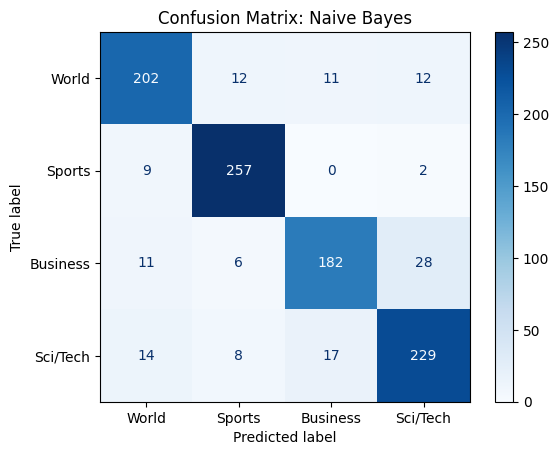

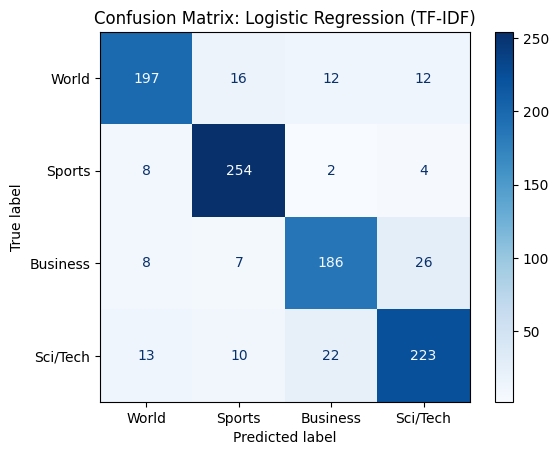

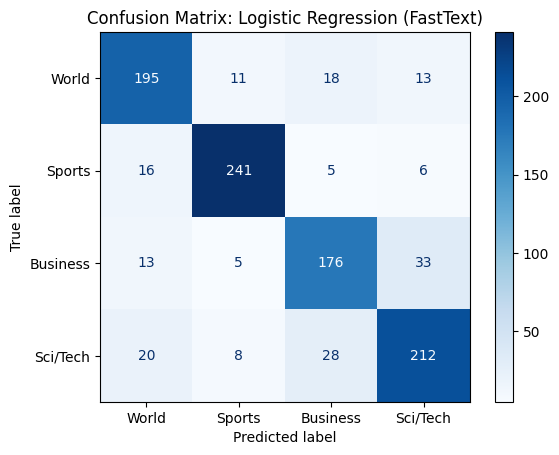

In [21]:
models_preds = {
    'Naive Bayes': y_pred_nb,
    'Logistic Regression (TF-IDF)': y_pred_lr,
    'Logistic Regression (FastText)': y_pred_ftlr
}

for model_name, preds in models_preds.items():
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['World', 'Sports', 'Business', 'Sci/Tech'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

## Plotting ROC Curves for Multi-Class Classification

After looking at confusion matrices,  
we now evaluate **model discrimination ability** using **ROC Curves** (Receiver Operating Characteristic curves).

**ROC Curve Concepts:**
- The ROC curve plots the **True Positive Rate (Recall)** against the **False Positive Rate** at different threshold settings.
- A **perfect classifier** would hug the **top-left corner** (high TPR, low FPR).
- The **Area Under the Curve (AUC)** summarizes this — higher AUC (close to 1) means better separability between classes.

**Steps:**
1. **Binarize** the multiclass labels using `label_binarize`, so we can compute ROC per class (one-vs-rest style).
2. Use the **decision scores** (raw confidence scores) from the Logistic Regression model (`decision_function`).
3. For each class:
   - Compute **FPR**, **TPR**, and **AUC**.
4. Plot all four ROC curves together for visual comparison.

**Why is this important?**
- ROC curves show not just *how often* the model is right, but *how confident* it is in making decisions.
- It helps detect cases where a model might have **high accuracy** but **poor probability calibration**.

This gives a **deeper understanding** of model quality beyond just precision, recall, and accuracy.


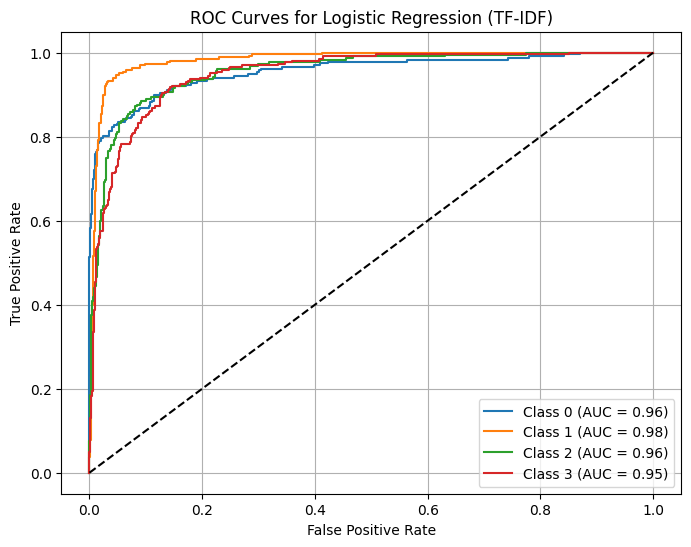

In [22]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0,1,2,3])
y_score = lr_model.decision_function(X_test_tfidf)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for Logistic Regression (TF-IDF)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

##  Error Analysis: Inspecting Misclassified Examples

Evaluating model metrics like accuracy and AUC is important,  
but to truly **understand** where a model struggles, we need to **look at individual mistakes**.

In this section, we:

- Identify test samples where the **predicted label** does not match the **true label**.
- Randomly select **5 misclassified examples** for manual inspection.
- Display:
  - The true label
  - The predicted label
  - A snippet (first 500 characters) of the text

**Why is this important?**
- Helps uncover **systematic confusion patterns** (e.g., mixing up "World" vs "Business" news).
- Highlights **edge cases** (ambiguous articles, noisy samples).
- Guides ideas for **improving data cleaning**, **feature engineering**, or **model architecture**.

**Best practices:**
- Regularly inspect model mistakes, especially when accuracy is already high.
- Think critically about **whether the error is due to model limits or data ambiguity**.

Error analysis bridges the gap between **automated evaluation** and **human understanding**!


In [24]:
from IPython.display import display, Markdown

# Find Mistakes
mistakes_idx = y_test != y_pred_ftlr
mistakes = pd.DataFrame({
    'Text': X_test[mistakes_idx],
    'True Label': y_test[mistakes_idx],
    'Predicted Label': y_pred_ftlr[mistakes_idx]
}).reset_index(drop=True)

# Random 5 samples
mistakes_sample = mistakes.sample(5, random_state=42)

# Display
for i, row in mistakes_sample.iterrows():
    display(Markdown(f"""
---
### ❌ Misclassified Example {i+1}
- **True Label**: `{row['True Label']}`
- **Predicted Label**: `{row['Predicted Label']}`

> {row['Text'][:500]}...
"""))



---
### ❌ Misclassified Example 20
- **True Label**: `0`
- **Predicted Label**: `1`

> it #39;s the occupation, stupid four years ago on sept. 28, 2000, when ariel sharon made his operatic visit to the temple mount, no one could have predicted how dire the situation would become so quickly: close to 6,000 dead; the building ...



---
### ❌ Misclassified Example 46
- **True Label**: `1`
- **Predicted Label**: `0`

> boxing: khan will keep feet on ground teenage boxing sensation amir khan punched is way to an olympic silver medal yesterday - then worried about his homework and passing his driving test....



---
### ❌ Misclassified Example 140
- **True Label**: `1`
- **Predicted Label**: `0`

> losing run is becoming a  quot;nightmare quot; - smith south africa captain graeme smith says his team #39;s losing run is reaching  quot;nightmare quot; proportions following their ninth successive defeat....



---
### ❌ Misclassified Example 31
- **True Label**: `1`
- **Predicted Label**: `2`

> plenty of options for washington the no. 2 oklahoma sooners would like the poll voters out there to understand just how difficult a task they accomplished saturday....



---
### ❌ Misclassified Example 68
- **True Label**: `3`
- **Predicted Label**: `0`

> the new pump the original version of reebok pump introduced in 1989 was inflated with the press of a pump button on the shoes tongue.  the new chinese-produced 2.0 silently inflates itself after you slip into it and take about five steps....


In [25]:
display(mistakes_sample[['Text', 'True Label', 'Predicted Label']])

,Text,True Label,Predicted Label
19,"it #39;s the occupation, stupid four years ago...",0,1
45,boxing: khan will keep feet on ground teenage ...,1,0
139,losing run is becoming a quot;nightmare quot;...,1,0
30,plenty of options for washington the no. 2 okl...,1,2
67,the new pump the original version of reebok pu...,3,0


##  Fine-tuning RoBERTa for News Classification

After experimenting with traditional ML models,  
we now fine-tune a **pre-trained Transformer model**: **RoBERTa-base** (Robustly Optimized BERT Pretraining Approach).


### Step 1: Define Evaluation Metrics

First, we define a `compute_metrics` function to evaluate model performance after each epoch.

This will give us **accuracy, precision, recall, and F1-score** during validation.


In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

### Step 2: Load Tokenizer and Model
We use Hugging Face's AutoTokenizer and AutoModelForSequenceClassification to load RoBERTa-base:
- We set `num_labels=4` because we have 4 news categories.

In [32]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model_bert = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Step 3: Tokenize Text Data

We tokenize the train and test sets with truncation, padding, and a maximum sequence length of 128:

In [33]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

### Step 4: Create a Dataset Class

We wrap the tokenized inputs into a PyTorch-style `Dataset` class:


In [ ]:
from torch.utils.data import Dataset

class TextDatasetBERT(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

### 🚀 Step 5: Build Datasets

We create `Dataset` objects for training and evaluation:


In [34]:
train_dataset_bert = TextDatasetBERT(train_encodings, y_train.tolist())
test_dataset_bert = TextDatasetBERT(test_encodings, y_test.tolist())

###  Step 6: Define Training Arguments

We configure the Hugging Face Trainer with our hyperparameters:
- 2 epochs of training
- batch size of 8
- evaluation after every epoch


In [36]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=10,
)

###  Step 7: Train the Model

We now initialize the Trainer and train the RoBERTa model:




In [37]:
from transformers import Trainer

trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset_bert,
    eval_dataset=test_dataset_bert,
    compute_metrics=compute_metrics
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.435700,0.377290,0.901000,0.901988,0.901000,0.901196
2,0.258900,0.374247,0.905000,0.909689,0.905000,0.905381


TrainOutput(global_step=1000, training_loss=0.4678340703845024, metrics={'train_runtime': 222.0264, 'train_samples_per_second': 36.032, 'train_steps_per_second': 4.504, 'total_flos': 526231560192000.0, 'train_loss': 0.4678340703845024, 'epoch': 2.0})

###  Step 8: Evaluate the Model

Finally, we evaluate the model on the test set:

`bert_acc` gives the final test accuracy.

In [38]:

eval_result = trainer.evaluate()
bert_acc = eval_result['eval_accuracy']

In [12]:
# @title Full Training
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model_bert = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

class TextDatasetBERT(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset_bert = TextDatasetBERT(train_encodings, y_train.tolist())
test_dataset_bert = TextDatasetBERT(test_encodings, y_test.tolist())

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset_bert,
    eval_dataset=test_dataset_bert,
    compute_metrics=compute_metrics
)

trainer.train()
eval_result = trainer.evaluate()
bert_acc = eval_result['eval_accuracy']


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.427000,0.673787,0.844000,0.862018,0.844000,0.844461
2,0.221000,0.386157,0.901000,0.905689,0.901000,0.901282


## Comparing Model Performance by F1-Score

Instead of comparing models purely by **accuracy**,  
we use the **F1-score**, which is the harmonic mean of **precision** and **recall**.

- **Accuracy** can be misleading if classes are imbalanced.
- **F1-score** gives a more balanced view of model performance.

We compare the following models:
- Naive Bayes (TF-IDF)
- Logistic Regression (TF-IDF)
- Logistic Regression (FastText Embeddings)
- RoBERTa Fine-tuning

Higher F1-score indicates better overall classification performance across classes.


<ipython-input-40-3caba3cbc214>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=model_f1s, palette='coolwarm')


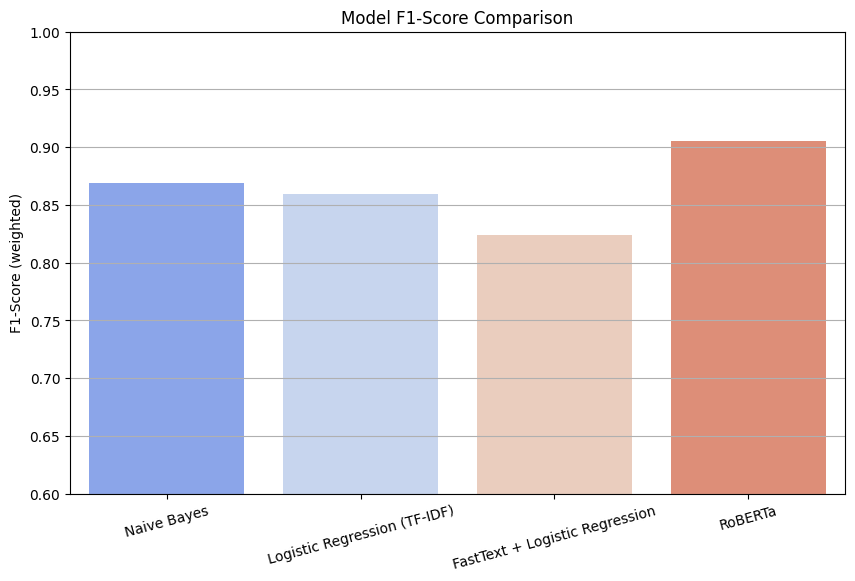

Naive Bayes: 0.8692
Logistic Regression (TF-IDF): 0.8593
FastText + Logistic Regression: 0.8241
RoBERTa: 0.9054


In [40]:
# Collect Model Names
model_names = ['Naive Bayes', 'Logistic Regression (TF-IDF)', 'FastText + Logistic Regression', 'RoBERTa']

# Collect F1 Scores
model_f1s = [
    classification_report(y_test, y_pred_nb, target_names=target_names, output_dict=True)['weighted avg']['f1-score'],
    classification_report(y_test, y_pred_lr, target_names=target_names, output_dict=True)['weighted avg']['f1-score'],
    classification_report(y_test, y_pred_ftlr, target_names=target_names, output_dict=True)['weighted avg']['f1-score'],
    eval_result['eval_f1']  # From Hugging Face Trainer evaluation
]

# Plot Comparison
plt.figure(figsize=(10,6))
sns.barplot(x=model_names, y=model_f1s, palette='coolwarm')
plt.ylim(0.6, 1.0)
plt.title('Model F1-Score Comparison')
plt.ylabel('F1-Score (weighted)')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

# Print F1-scores nicely
for name, f1 in zip(model_names, model_f1s):
    print(f"{name}: {f1:.4f}")





## Text Classification Cheatsheet

| Term | Definition |
|:---|:---|
| **Text Classification** | Assigning categories to text based on content. |
| **TF-IDF** | Scores words by importance (high if frequent in one doc but rare across corpus). |
| **Naive Bayes** | Probabilistic model assuming word independence, often used with TF-IDF. |
| **Transformer** | Deep learning model based on self-attention (captures context more efficiently than RNNs). |
| **Fine-tuning** | Retraining a pre-trained model slightly on a new dataset to adapt it to a new task. |
| **AG News Dataset** | English news dataset with 4 classes: World, Sports, Business, Sci/Tech. |
| **Precision** | Correct positive predictions divided by total positive predictions. |
| **Recall** | Correct positive predictions divided by all actual positives. |
| **F1 Score** | Harmonic mean of precision and recall (good for imbalanced datasets). |

---



# Bonus Quiz: Text Classification Concepts

Welcome to a quick 5-question MCQ quiz to test your understanding of text classification!

---

### **1. What is the main assumption of the Naive Bayes algorithm?**
- a) Words are dependent on each other  
- b) Words are independent of each other  
- c) Words must be ordered correctly  
- d) None of the above  

<details>
<summary>Answer</summary>
<b>Answer:</b> b) Words are independent of each other
</details>

---

### **2. Why do we use TF-IDF instead of simple word counts?**
- a) To capture word ordering  
- b) To emphasize rare but important words  
- c) To reduce computation time  
- d) To increase sentence length  

<details>
<summary>Answer</summary>
<b>Answer:</b> b) To emphasize rare but important words
</details>


---

### **3. What is the purpose of word embeddings like FastText?**
- a) Represent words using one-hot encoding  
- b) Represent words as dense vectors capturing meaning  
- c) Increase vocabulary size  
- d) Speed up data loading  

<details>
<summary>Answer</summary>
<b>Answer:</b> b) Represent words as dense vectors capturing meaning
</details>



---

### **4. What is the key innovation behind Transformers?**
- a) Replacing word embeddings with bag-of-words  
- b) Using self-attention instead of recurrence  
- c) Using convolution layers instead of dense layers  
- d) Training without GPUs  

<details>
<summary>Answer</summary>
<b>Answer:</b> b) Using self-attention instead of recurrence
</details>

---

### **5. Fine-tuning a model like RoBERTa requires:**
- a) Starting training from scratch  
- b) Only training the last output layer  
- c) Slightly updating all pre-trained weights  
- d) Ignoring pre-trained weights  

<details>
<summary>Answer</summary>
<b>Answer:</b> c) Slightly updating all pre-trained weights
</details>
